In [11]:
import pandas as pd
import numpy as np
from pmdarima import auto_arima
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import os
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Definir a semente para reprodução dos resultados
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)


In [12]:
#Leitura de dados
df = pd.read_csv('data_per_month.csv')

In [13]:
data = df.copy()

train_size = int(len(data) * 0.8)  # 80% treino, 20% teste
train, test = data[:train_size], data[train_size:]

In [14]:
from statsmodels.tsa.stattools import adfuller

# Executar o teste ADF na série original
result = adfuller(train['Total Renewable Energy'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# Transformação Logarítmica
train = train.copy()
train.loc[:, 'Log'] = np.log(train['Total Renewable Energy'])
# Verificando a série transformada
print(train)

ADF Statistic: -0.8973051747779103
p-value: 0.7888585668091624
     Year  Month  Day  Total Renewable Energy   Data Time       Log
0    1973      1   26                 219.840  1973-01-26  5.392900
1    1973      2   26                 197.330  1973-02-26  5.284877
2    1973      3   26                 218.687  1973-03-26  5.387641
3    1973      4   26                 209.330  1973-04-26  5.343912
4    1973      5   26                 215.982  1973-05-26  5.375195
..    ...    ...  ...                     ...         ...       ...
485  2013      6   26                 457.129  2013-06-26  6.124966
486  2013      7   26                 462.057  2013-07-26  6.135688
487  2013      8   26                 434.547  2013-08-26  6.074304
488  2013      9   26                 408.686  2013-09-26  6.012947
489  2013     10   26                 428.271  2013-10-26  6.059756

[490 rows x 6 columns]


1
0
0
ADF Statistic: -6.142712799282531
p-value: 7.900331345240322e-08


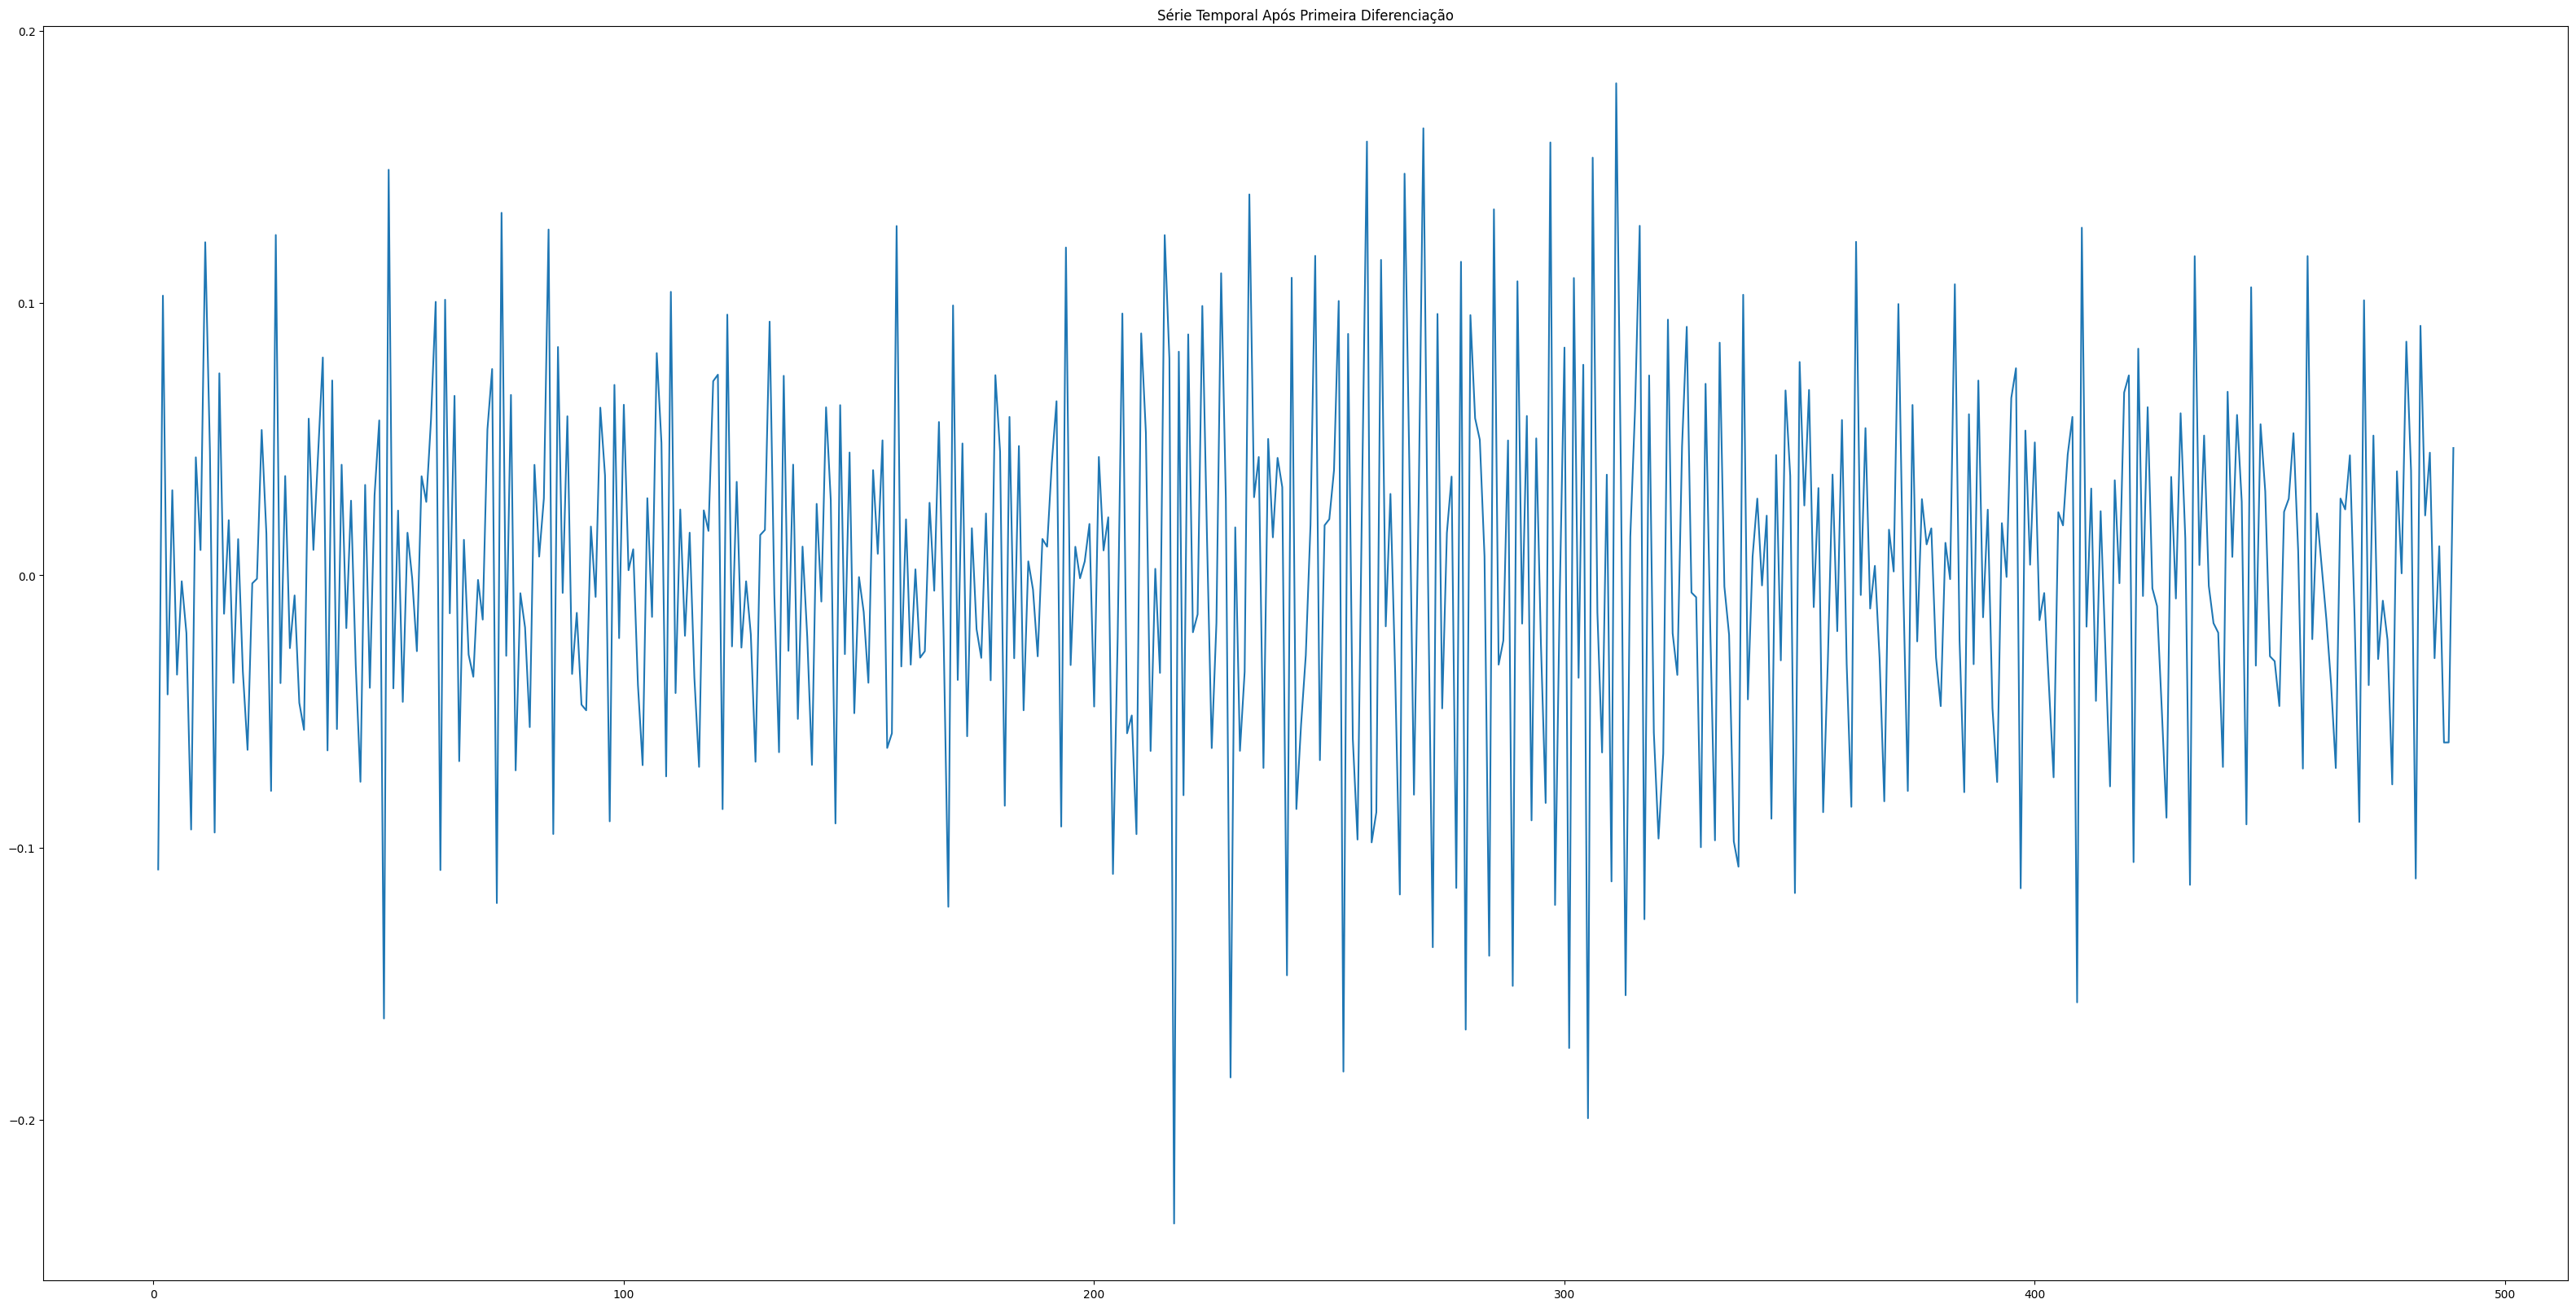

,Year,Month,Day,Total Renewable Energy,Data Time,Log,Diff
1,1973,2,26,197.330,1973-02-26,5.284877,-0.108023
2,1973,3,26,218.687,1973-03-26,5.387641,0.102764
3,1973,4,26,209.330,1973-04-26,5.343912,-0.043730
4,1973,5,26,215.982,1973-05-26,5.375195,0.031283
5,1973,6,26,208.249,1973-06-26,5.338734,-0.036461
...,...,...,...,...,...,...,...
485,2013,6,26,457.129,2013-06-26,6.124966,-0.030415
486,2013,7,26,462.057,2013-07-26,6.135688,0.010723
487,2013,8,26,434.547,2013-08-26,6.074304,-0.061384
488,2013,9,26,408.686,2013-09-26,6.012947,-0.061357


In [15]:
# Aplicar a primeira diferenciação
initial_value = train['Log'].loc[0]
train.loc[:, ['Diff']] = train['Log'].diff().dropna()

# Verificar se há valores NaN ou Inf no DataFrame
print(train['Diff'].isna().sum())  # Contar quantos NaN existem
print((train['Diff'] == np.inf).sum())  # Contar quantos Inf existem

# Remover valores NaN ou Inf
train_cleaned = train['Diff'].replace([np.inf, -np.inf], np.nan).dropna()

# Verifique novamente
print(train_cleaned.isna().sum())  # Agora deve ser 0

# Agora execute o teste ADF
result_diff1 = adfuller(train_cleaned)
print('ADF Statistic:', result_diff1[0])
print('p-value:', result_diff1[1])

# Plotar a série diferenciada
plt.figure(figsize=(40, 20))
plt.plot(train['Diff'])
plt.title('Série Temporal Após Primeira Diferenciação')
plt.show()

train = train.dropna()
train

# train['Diff'] = pd.DataFrame(train['Diff'])

In [16]:
from pmdarima import auto_arima

# Treinando o modelo AutoARIMA nos dados diferenciais
model = auto_arima(train["Diff"].dropna(), 
                   seasonal=True, m=12, 
                   trace=True, error_action="ignore", 
                   suppress_warnings=True)

# Fazendo previsões para o conjunto de teste
forecast = model.predict(n_periods=len(test))

# Reverter a diferenciação
last_value_train_log = train["Log"].iloc[-1]
y_pred_log = [last_value_train_log]

for value in forecast:
    y_pred_log.append(y_pred_log[-1] + value)

y_pred_log = np.array(y_pred_log[1:])  # Removendo o primeiro valor extra

# Reverter a transformação logarítmica
y_pred = np.exp(y_pred_log)

# Exibir previsões
print("Previsões:", y_pred)


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=-1711.890, Time=0.79 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-1247.047, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-1583.481, Time=0.24 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-1500.378, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-1248.847, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=-1505.943, Time=0.66 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=-1618.964, Time=0.64 sec
 ARIMA(2,0,2)(2,0,1)[12] intercept   : AIC=-1708.480, Time=1.71 sec
 ARIMA(2,0,2)(1,0,2)[12] intercept   : AIC=-1709.186, Time=1.68 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=-1381.799, Time=0.31 sec
 ARIMA(2,0,2)(0,0,2)[12] intercept   : AIC=-1563.199, Time=1.57 sec
 ARIMA(2,0,2)(2,0,0)[12] intercept   : AIC=-1674.917, Time=1.73 sec
 ARIMA(2,0,2)(2,0,2)[12] intercept   : AIC=-1716.439, Time=1.91 sec
 ARIMA(1,0,2)(2,0,2)[12] intercept   : AIC=-1718.260, Time=1.96 sec
 ARIM

C:\Users\olihe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\olihe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


RMSE: 31.07
MAE: 24.33
MAPE: 4.86%
R²: 0.2865


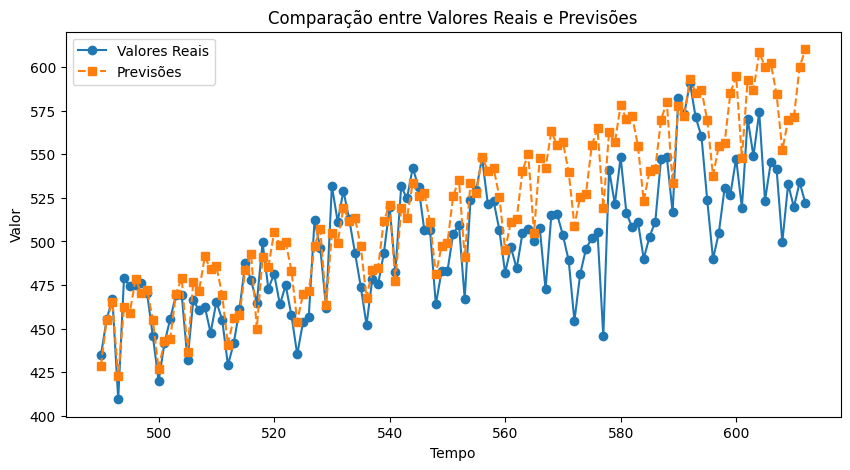

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Reverter a diferenciação
last_value_train_log = train["Log"].iloc[-1]
y_pred_log = [last_value_train_log]

for value in forecast:
    y_pred_log.append(y_pred_log[-1] + value)

y_pred_log = np.array(y_pred_log[1:])  # Remover o primeiro valor extra

# Reverter a transformação logarítmica
y_pred = np.exp(y_pred_log)
y_true = test['Total Renewable Energy'].values

# Cálculo das métricas
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

# Exibir métricas
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

# Plot da comparação entre valores reais e previstos
plt.figure(figsize=(10, 5))
plt.plot(test.index, y_true, label="Valores Reais", marker="o")
plt.plot(test.index, y_pred, label="Previsões", linestyle="dashed", marker="s")
plt.legend()
plt.title("Comparação entre Valores Reais e Previsões")
plt.xlabel("Tempo")
plt.ylabel("Valor")
plt.show()
